/Users/amolk/work/free-energy-minimization-framework/10
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


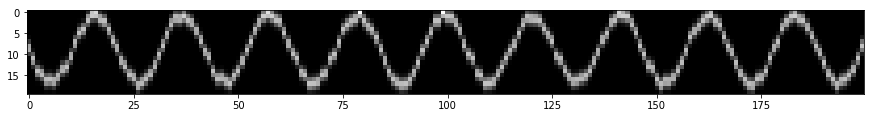

torch.Size([159, 40, 20])
torch.Size([159, 40, 20])


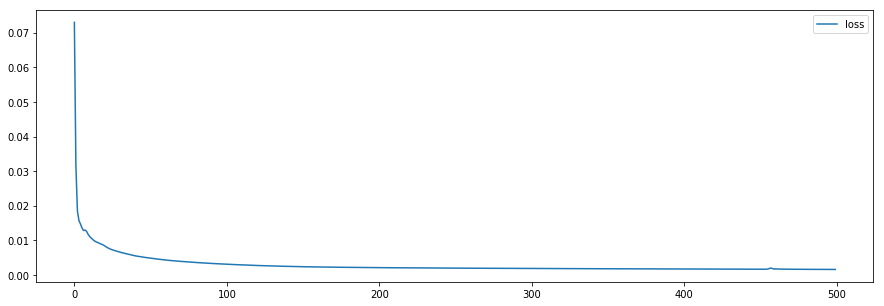

No handles with labels found to put in legend.


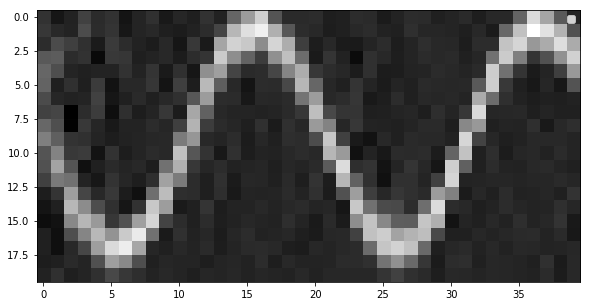

In [2]:
# Use the probability distribution encoding explored in 9
# to predict a bit more complex function

# %%
%cd ~/work/free-energy-minimization-framework/10/
%load_ext autoreload
%autoreload 2

# %%
import torch
from torch import nn
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

from scipy.stats import norm

def normal_distribution(n, mean, var=0.05):
  x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
  x = x / np.sum(x)
  return torch.tensor(x).float()

figsize=(15,5)
learning_rate = 0.01
quantization = 20

# %%
pattern_length = 200
pattern_floats = torch.tensor((np.sin(np.arange(pattern_length) * 0.30) + 1 + np.random.sample(int(pattern_length)) * 0.2) / 2.5).float()
pattern = torch.stack([normal_distribution(quantization, val) for val in pattern_floats])

plt.figure(figsize=figsize)
plt.imshow(pattern.t().numpy(), cmap='gray', label='pattern')
plt.show()

# %%
t_sample = 40
batch_size = pattern_length - t_sample - 1
input = torch.stack([pattern[i:i+t_sample] for i in np.arange(batch_size)])
print(input.shape)
target = torch.stack([pattern[i+1:i+t_sample+1] for i in np.arange(batch_size)])
print(target.shape)

# print('input', input, 'target', target)
hidden_size = t_sample

# %%
num_layers=3
rnn = nn.RNN (
  input_size=quantization,
  hidden_size=quantization,
  num_layers=num_layers,
  nonlinearity='tanh',
  batch_first=True
)

# linear = nn.Linear (
#   hidden_size,
#   quantization
# )

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
epoch = 0
losses = []
while epoch < 500:
  rnn.zero_grad()
  state = torch.zeros(num_layers, batch_size, quantization)
  out, state = rnn(input, state)
  # out = linear(out)
  # print('out', out)
  # print('state', state)
  loss = torch.nn.functional.mse_loss(out, target)
  loss.backward()
  optimizer.step()
  # print('loss', loss)
  losses.append(loss)
  epoch += 1

plt.figure(figsize=figsize)
plt.plot(losses, label='loss')
plt.legend()
plt.show()

# %%

state = torch.zeros(num_layers, batch_size, quantization)
out, state = rnn(input, state)

plt.figure(figsize=figsize)
plt.imshow(out[20].detach().t(), cmap='gray', label='output')
plt.legend()
plt.show()


## Learning probability distribution from noisy input

Each value in the noisy sin wave is represented as a PDF - each column in the first figure. The second figure shows output of an RNN for a subsequence. The "spread" of the sin wave is proportional to the noise in the input.

An observation is that the sin wave is surrounded by darker (lower probability) cells. Not sure what that means exactly, but might be related to edge detection/center-surround type neural dynamics.